In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
credits = pd.read_csv('tmdb_5000_credits.csv')
movies = pd.read_csv('tmdb_5000_movies.csv')

In [3]:
# check shapes
print(credits.shape)
print(movies.shape)

(4803, 4)
(4803, 20)


In [4]:
# check missings
print(credits.isnull().sum())
print()
print(movies.isnull().sum())

movie_id    0
title       0
cast        0
crew        0
dtype: int64

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64


In [5]:
# check for duplicate movies
print(credits['movie_id'].duplicated().sum())
print()
print(movies['id'].duplicated().sum())

0

0


In [6]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


Features are stored inside a list of dictionaries so elements must be extracted using the following functions.

In [7]:
def get_features(cast):
    
    output = []
    for x in ast.literal_eval(cast):
        output.append(x.get('name'))
    return np.unique(np.array(output)).tolist() 

In [8]:
def get_director(crew):
    
    for member in ast.literal_eval(crew):
        if member.get('job') == 'Director':
            return member.get('name')

In [9]:
# the director of the movie may be a good predictor giving people watch movies by similar directors
credits['Director'] = credits['crew'].apply(lambda x: get_director(x))
credits.drop(columns=['crew'], inplace=True)

In [10]:
credits.isnull().sum()
# 30 missing directors can be filled with unknown

movie_id     0
title        0
cast         0
Director    30
dtype: int64

In [804]:
credits['Director'].fillna('Unknown', inplace=True)

In [805]:
# create binary columns for each string in the list
credits_dummies = pd.get_dummies(credits['Director'].apply(pd.Series).stack()).sum(level=0)

# concatenate the dummy columns with the original DataFrame
credits = pd.concat([credits, credits_dummies], axis=1)

Could potentially get more out of the cast column but due to the resulting size of the dataset after considering all possible actors, I will drop this.

In [808]:
credits.drop(columns=['cast'], inplace = True)

In [809]:
# Will sort out other dataset
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [810]:
movies['status'].value_counts().apply(lambda x: x / movies['status'].shape[0])
# will drop this as this should not determine whether something is recommended

Released           0.998334
Rumored            0.001041
Post Production    0.000625
Name: status, dtype: float64

In [811]:
movies['original_language'].value_counts()
# will drop this should not determine whether something is recommended

en    4505
fr      70
es      32
zh      27
de      27
hi      19
ja      16
it      14
cn      12
ru      11
ko      11
pt       9
da       7
sv       5
fa       4
nl       4
he       3
th       3
ta       2
id       2
ro       2
ar       2
cs       2
el       1
af       1
is       1
pl       1
sl       1
tr       1
vi       1
ky       1
xx       1
nb       1
no       1
ps       1
te       1
hu       1
Name: original_language, dtype: int64

In [812]:
movies.loc[0, 'keywords']
# as with actors, this is quite granular so will opt to remove it for now

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [813]:
movies['genres'] = movies['genres'].apply(lambda x: get_features(x))

In [814]:
movies.drop(columns=['homepage', 'keywords', 'original_title', 'production_companies', 'production_countries', 
                     'release_date', 'spoken_languages', 'status', 'title', 'tagline', 'original_language',
                    # going to drop budget and revenue as not suitable for recommendation system
                     'budget', 'revenue'], inplace=True)

In [815]:
# create binary columns for each string in the list
movies_dummies = pd.get_dummies(movies['genres'].apply(pd.Series).stack()).sum(level=0)

# concatenate the dummy columns with the original DataFrame
movies = pd.concat([movies, movies_dummies], axis=1)
movies.drop(columns=['genres'], inplace=True)

In [816]:
# 3 titles had a nan overview which will cause problems in a minute. 
# Will fill the nan with an empty string instead
movies['overview'].fillna('', inplace=True)

In [817]:
movies.isnull().sum()

id                  0
overview            0
popularity          0
runtime             2
vote_average        0
vote_count          0
Action             28
Adventure          28
Animation          28
Comedy             28
Crime              28
Documentary        28
Drama              28
Family             28
Fantasy            28
Foreign            28
History            28
Horror             28
Music              28
Mystery            28
Romance            28
Science Fiction    28
TV Movie           28
Thriller           28
War                28
Western            28
dtype: int64

In [818]:
movies.fillna(0, inplace=True)
# most missings remaining are binaries created by me earlier so will fill with 0.
# 2 cases with missing run time will have missings replaced with average later

In [819]:
df = credits.merge(movies, left_on= 'movie_id', right_on='id')

In [820]:
vectorizer = TfidfVectorizer(stop_words='english')
#Transform to vectors
text_vectors = vectorizer.fit_transform(df['overview'])

# Convert the sparse matrix to a DataFrame
text_vectors_df = pd.DataFrame(text_vectors.toarray(), columns=vectorizer.get_feature_names_out())

df.drop(columns=['overview'], inplace=True)

# Concatenate the original DataFrame with the text vectors DataFrame
df = pd.concat([df, text_vectors_df], axis=1)

## EDA

Running some analysis on remaining fields to determine whether they are wanted in the system.
Will consider the following analyses:

* Distribution of average ratings
* Ratings by director
* Distribution of run time and missings check


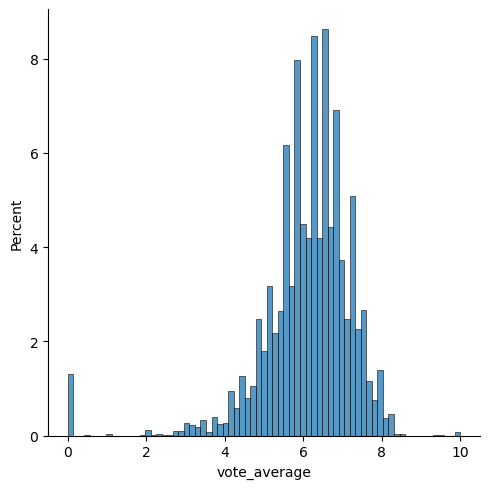

In [821]:
sns.displot(df['vote_average'],stat='percent', kind='hist')

In [822]:
# significant number of titles have a rating of zero, will look into this a bit
zero_ratings = df.loc[df['vote_average'] == 0,:]

In [823]:
zero_ratings['vote_count'].value_counts()
# zero ratings are driven by low number of votes. Seems that 0 is assigned when no one votes

0    62
1     1
Name: vote_count, dtype: int64

In [824]:
directors = df.loc[:, ['Director', 'vote_count', 'vote_average']].groupby('Director')

votes = directors.agg({'vote_count': ['sum'], 'vote_average': 'mean'})
counts = directors.size()
votes['counts'] = counts

In [825]:
votes.sort_values('counts', ascending=False).head()
# will get rid of unknown for any other EDA

,vote_count,vote_average,counts
,sum,mean,
Director,,,
Unknown,70,3.386667,30
Steven Spielberg,59771,6.974074,27
Woody Allen,9654,6.685714,21
Martin Scorsese,32866,7.295000,20
Clint Eastwood,19400,6.865000,20


In [826]:
votes = votes.drop(votes[votes.index == 'Unknown'].index)

In [827]:
votes.sort_values('counts', ascending=False).head()

,vote_count,vote_average,counts
,sum,mean,
Director,,,
Steven Spielberg,59771,6.974074,27
Woody Allen,9654,6.685714,21
Martin Scorsese,32866,7.295000,20
Clint Eastwood,19400,6.865000,20
Spike Lee,3465,6.456250,16


Given we do not have user data and not sure where a vote comes from, we will not consider the rating or vote count in the system. 

The reason for this is that we do not want to recommend a movie just because it is rated similarly to another movie without any idea if common users are rating them.

In [828]:
df.drop(columns=['vote_average', 'vote_count', 'popularity'], inplace=True)

Will now look at runtime. There may be a case to use this in the model as may make a recommendation to someone who likes short movies.

If it is used, it will need to be scaled.

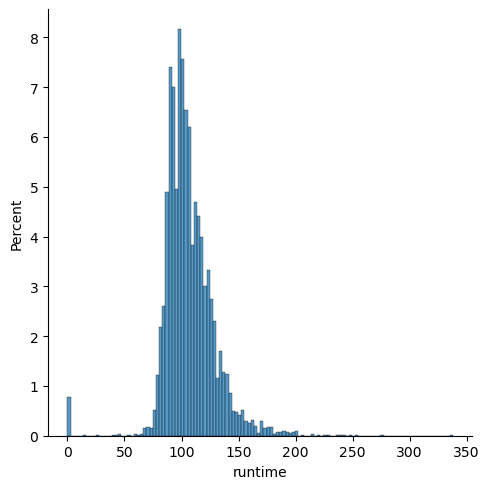

In [829]:
sns.displot(df['runtime'],stat='percent', kind='hist')

In [830]:
# Will have a look at 0 run time cases.
zero_ratings = df.loc[df['runtime'] == 0,:]

In [831]:
zero_ratings.shape
# some of these look like genuine movies so the 0 run time appears to be a data quality issue
# will replace the 0 with the average for now

(37, 23352)

In [832]:
avg_runtime = df.loc[df['runtime'] > 0, 'runtime'].mean()

print(avg_runtime)

107.66072177926983


In [833]:
df['runtime'] = df['runtime'].apply(lambda x: avg_runtime if x == 0 else x)

In [834]:
# now to normalise between 0 and 1
normalizer = Normalizer()

df['runtime'] = normalizer.fit_transform(df[['runtime']]).flatten()

## Now time to get similarity between movies based on all remaining data.

In [835]:
columns_to_ignore = ['title', 'id', 'movie_id', 'Director']
columns_to_consider = [col for col in df.columns if col not in columns_to_ignore]

In [836]:
similarity = cosine_similarity(df.loc[:, columns_to_consider])

<AxesSubplot:>

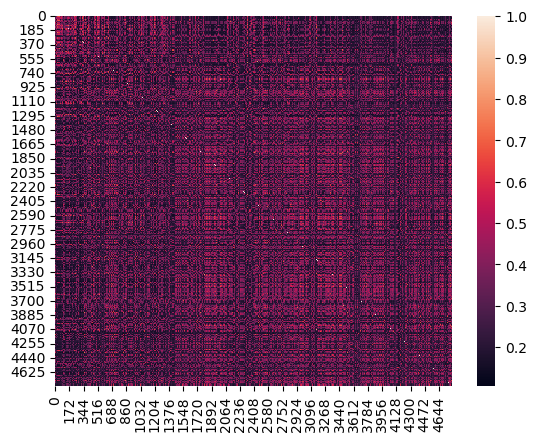

In [837]:
sns.heatmap(similarity)

In [838]:
# gunction to get the top N most similar documents
def get_top_similar_documents(title, similarity_matrix, df, top_n=10):
    # get the index of the given title
    title_index = df.index[df['title'].iloc[:,0] == title].tolist()[0]

    # cosine similarity scores for the given title
    sim_scores = list(enumerate(similarity_matrix[title_index]))

    # sort the documents based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # indices of the top n similar documents (not including document itself at index 0)
    top_indices = [i[0] for i in sim_scores[1:top_n + 1]]  

    # titles of the top N similar documents
    top_titles = df['title'].iloc[top_indices]

    return top_titles.iloc[:,0]

In [839]:
query_title = "The Lord of the Rings: The Fellowship of the Ring"
top_similar_documents = get_top_similar_documents(query_title, similarity, df)

print(f"Top 10 documents similar to '{query_title}':")
print(top_similar_documents)

Top 10 documents similar to 'The Lord of the Rings: The Fellowship of the Ring':
98                  The Hobbit: An Unexpected Journey
329     The Lord of the Rings: The Return of the King
330             The Lord of the Rings: The Two Towers
19          The Hobbit: The Battle of the Five Armies
22                The Hobbit: The Desolation of Smaug
1438                                            Krull
379                               Conan the Barbarian
20                             The Amazing Spider-Man
786                                 The Monkey King 2
17        Pirates of the Caribbean: On Stranger Tides
Name: title, dtype: object
